In [1]:
from collections import defaultdict
import datetime
from pathlib import Path
import pickle

import numpy as np
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.units as munits
import seaborn as sns

from e2ools.models import teem, hollywood
from e2ools import utils


In [ ]:
%matplotlib inline
sns.set()
sns.set_context('paper')

converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter



data_paths = {'Windows': Path('C:\\Users\\Brandon\\Dropbox\\enron_dataset\\'),
                'Linux': Path('/home/boselio/Dropbox/enron_dataset/'),
                'Mac':  Path('/Users/boselio/Dropbox/enron_dataset/')}

data_path = data_paths['Windows']

save_paths = {'Windows': Path('C:\\Users\\Brandon\\Dropbox\\teem\\experiments\\kaminsky_experiment_modified\\'),
                'Linux': Path('/home/boselio/Dropbox/teem/experiments/kaminsky_experiment_modified/'),
                'Mac':  Path('/Users/boselio/Dropbox/teem/experiments/kaminsky_experiment_modified/')}

save_dir = save_paths['Windows']

file_path = data_path / 'enron_interactions_time_ordered_no_duplicates_w_time.csv'

interactions = []
with file_path.open('r') as infile:
    for line in infile:
        verts = [int(v) for v in line.split(',')]
        interactions.append([verts[0], [verts[1], verts[2:]]])


In [2]:
interactions_by_sender = defaultdict(list)
for t, [s, recs] in interactions:
    interactions_by_sender[s].append([t, recs])
#Kaminsky = 76795
sender = 76795

In [3]:
kaminsky_interactions = []
#rewrite the receivers so that they are from 0 - k.
original_to_inference = dict()
counter = 0
for [t, recs] in interactions_by_sender[sender][1:]:
    temp_recs = []
    for r in recs:
        if r not in original_to_inference:
            original_to_inference[r] = counter
            counter += 1
        temp_recs.append(original_to_inference[r])
    kaminsky_interactions.append([t, temp_recs])

#Get rid of the last two interactions - they are essentially outliers
kaminsky_interactions = kaminsky_interactions[:-2]

In [4]:
inference_to_original = {v: k for (k, v) in original_to_inference.items()}
inference_to_original[2], inference_to_original[31]

(76960, 29236)

In [5]:
with (data_path / 'nodes.pkl').open('rb') as infile:
    original_to_name = pickle.load(infile)
    
original_to_name[76960], original_to_name[29236]

('vkaminski@aol.com', 'grant.masson@enron.com')

In [6]:
len(kaminsky_interactions)

3745

In [7]:
len(set([r for interaction in kaminsky_interactions for r in interaction[1]]))

784

In [8]:
#Modify the dataset so there are no multiples
times = [i[0] for i in kaminsky_interactions]
eps_multi = np.diff(times).min() / 250

new_interactions = []
for t, rec_list in kaminsky_interactions:
    if len(rec_list) == 1:
        new_interactions.append([t, rec_list])
    else:
        for i, r in enumerate(rec_list):
            new_interactions.append([t + i * eps_multi, [r]])
            
del kaminsky_interactions
kaminsky_interactions = new_interactions

In [9]:
times = [i[0] for i in kaminsky_interactions]
datetimes = [datetime.datetime.fromtimestamp(t * 1e-9) for t in times]

In [10]:
datetimes[0], datetimes[-1]

(datetime.datetime(1999, 12, 10, 5, 13),
 datetime.datetime(2001, 5, 7, 18, 41, 0, 240000))

In [11]:
max_time = max([t for [t, recs] in kaminsky_interactions])
min_time = min([t for [t, recs] in kaminsky_interactions])
transformed_times = [(t - min_time) / (max_time - min_time) * 100 for t in times]
time_dict = {k: v for (k, v) in zip(transformed_times, datetimes)}

kaminsky_interactions = [[(t - min_time) / (max_time - min_time) * 100, recs] for [t, recs] in kaminsky_interactions]


C:\Users\Brandon\anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  if sys.path[0] == '':


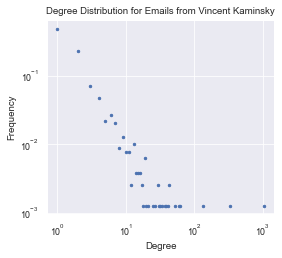

In [12]:
fig, ax = plt.subplots(figsize=(4,4))

unique_receivers, receiver_count = np.unique([r for [t, recs] in kaminsky_interactions for r in recs], return_counts=True)
total_receivers = np.sum(receiver_count)
degs, deg_freq = np.unique(receiver_count, return_counts=True)
ax.loglog(degs, deg_freq / deg_freq.sum(), '.')
ax.set_aspect('equal')
ax.set_xlabel('Degree')
ax.set_ylabel('Frequency')
ax.set_title('Degree Distribution for Emails from Vincent Kaminsky')
fig.tight_layout()
fig.savefig('kaminsky_degree_plot.png', type='png', dpi=1000)

In [13]:
nodes_sorted_by_degrees = np.argsort(receiver_count)[::-1]
cumulative_emails, (x_all, y_all) = utils.get_cumulative_node_data(kaminsky_interactions, return_total=True)

In [14]:
x_dates_all = [time_dict[t] for t in x_all]
x_2_dates = [time_dict[t] for t in cumulative_emails[2][0]]
x_31_dates = [time_dict[t] for t in cumulative_emails[31][0]]

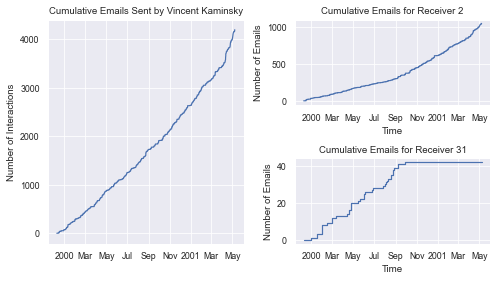

In [15]:
gs = gridspec.GridSpec(2, 2,)
full_ax = plt.subplot(gs[:, 0])
fig = full_ax.get_figure()
fig.set_size_inches(7, 4)
ax_2 = plt.subplot(gs[0, 1])
ax_31 = plt.subplot(gs[1,1])

full_ax.plot(x_dates_all, y_all)
full_ax.set_title('Cumulative Emails Sent by Vincent Kaminsky')
#full_ax.set_xlabel('Time')
full_ax.set_ylabel('Number of Interactions')

ax_2.plot(x_2_dates, cumulative_emails[2][1])
ax_2.set_title('Cumulative Emails for Receiver 2')
ax_2.set_xlabel('Time')
ax_2.set_ylabel('Number of Emails')

ax_31.plot(x_31_dates, cumulative_emails[31][1])
ax_31.set_title('Cumulative Emails for Receiver 31')
ax_31.set_xlabel('Time')
ax_31.set_ylabel('Number of Emails')

fig.tight_layout()

In [16]:
fig.savefig('cum_exs_kaminsky.png', type='png', dpi=500)

C:\Users\Brandon\anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  """Entry point for launching an IPython kernel.


In [17]:
num_recs_per_interaction = [len(interaction[-1]) for interaction in
                           kaminsky_interactions]
max(num_recs_per_interaction)

1

In [18]:
kaminsky_interactions[:20]

[[0.0, [0]],
 [0.027533782723178676, [1]],
 [0.03873625314486412, [2]],
 [0.7384182611691694, [3]],
 [0.9488357477644418, [4]],
 [0.9505903515654286, [5]],
 [1.122946432631601, [6]],
 [1.1241611583399767, [5]],
 [1.1252409145251991, [7]],
 [1.125375884048352, [8]],
 [1.1257807926178107, [9]],
 [1.1257813324959032, [10]],
 [1.1259157621409634, [11]],
 [1.1672164362257316, [2]],
 [1.167486375272037, [5]],
 [1.1678912838414957, [12]],
 [1.168296192410954, [13]],
 [1.3621124276584275, [14]],
 [1.362517336227886, [15]],
 [1.363597092413109, [2]]]

In [19]:
#Run e2 model to get initial alpha and theta
e2_est = hollywood.E2Estimator()
interactions_no_time = [interaction[1] for interaction in kaminsky_interactions]
e2_est.fit(interactions_no_time)
alpha_init = e2_est.alphas[-1][0]
theta_init = e2_est.thetas[-1][0]

In [20]:
alpha_init

0.4892556997906204

In [21]:
save_dir

WindowsPath('C:/Users/Brandon/Dropbox/teem/experiments/kaminsky_experiment_modified')

In [22]:
teem.infer_teem(kaminsky_interactions, alpha_priors=(1,1), theta_priors=(2, 5), nu=1, 
                save_dir=save_dir, num_iters_per_chain=500)

Creating Necessary Parameters
Beginning Inference:
Number of change times: 98
Number of change times: 104
Number of change times: 112
Number of change times: 105
0
0
0
0


KeyboardInterrupt: 

In [22]:
with (save_dir / 'prob_avgs.pkl').open('rb') as infile:
    temp = pickle.load(infile)
probs_ul = temp['upper_limits'] 
probs_ll = temp['lower_limits'] 
probs = temp['means'] 
times = temp['times']


In [23]:
utils.plot_teem_debug_plots(kaminsky_interactions, probs, probs_ul, probs_ll, 
                            times, plot_events=True, 
                            r_list='top10', save_dir=save_dir / 'kaminsky_plots_top10.pdf', gibbs_dir=save_dir, num_chains=4,
                           num_iters_per_chain=500)

In [19]:
kaminsky_interaction_times = np.array([interaction[0] for interaction 
                                       in kaminsky_interactions])
kaminsky_num_recs = np.array([len(interaction[-1]) for interaction 
                              in kaminsky_interactions])

In [15]:
utils.create_pp_datasets(save_dir, kaminsky_interaction_times, kaminsky_num_recs, 4, 250)   

/home/boselio/code/e2ools/e2ools/utils.py:276: RuntimeWarning: invalid value encountered in true_divide
  probs_array = probs_array / probs_sum
/home/boselio/code/e2ools/e2ools/utils.py:276: RuntimeWarning: invalid value encountered in true_divide
  probs_array = probs_array / probs_sum
/home/boselio/code/e2ools/e2ools/utils.py:276: RuntimeWarning: invalid value encountered in true_divide
  probs_array = probs_array / probs_sum
/home/boselio/code/e2ools/e2ools/utils.py:276: RuntimeWarning: invalid value encountered in true_divide
  probs_array = probs_array / probs_sum
/home/boselio/code/e2ools/e2ools/utils.py:276: RuntimeWarning: invalid value encountered in true_divide
  probs_array = probs_array / probs_sum
/home/boselio/code/e2ools/e2ools/utils.py:276: RuntimeWarning: invalid value encountered in true_divide
  probs_array = probs_array / probs_sum
/home/boselio/code/e2ools/e2ools/utils.py:276: RuntimeWarning: invalid value encountered in true_divide
  probs_array = probs_array / pr

In [20]:
pp_save_dir = save_dir / 'pp_data'
num_chains = 4
num_iters = 250

pp_save_dirs = [pp_save_dir / '{}'.format(c) / '{}.dat'.format(i) 
                for c in range(num_chains)
                for i in range(num_iters)]

mean_degree_dict = defaultdict(int)
ppc_list = []
num_recs = len(set([r for interaction in kaminsky_interactions for r in interaction[-1]]))
ppc_mean_array = np.zeros((num_recs + 1, kaminsky_interaction_times.shape[0]))

for i, ppsp in enumerate(pp_save_dirs):
    pp_interactions = utils.load_interactions(ppsp)
    nodes, degrees = np.unique([r for interaction in pp_interactions for r in interaction[-1]],
                           return_counts=True)
    pp_unique_degrees, pp_degree_counts = np.unique(degrees, return_counts=True)
    
    for k, v in zip(pp_unique_degrees, pp_degree_counts):
        mean_degree_dict[k] += v
    
    interaction_time_by_rec = defaultdict(list)
    for t, interaction_recs in pp_interactions:
        for r in interaction_recs:
            interaction_time_by_rec[r].append(t)
    
    #Create the ppc_array
    for ii, (t, recs) in enumerate(pp_interactions):
        for r in recs:
            ppc_mean_array[r, ii] += 1
    ppc_list.append(interaction_time_by_rec)
    
ppc_mean_array = np.cumsum(ppc_mean_array, axis=1)
ppc_mean_array /= len(pp_save_dirs)

In [21]:
int_time_to_ind = {t: i for i, t in enumerate(kaminsky_interaction_times)}
alpha = 95
ppc_alpha = np.zeros_like(ppc_mean_array)
ppc_1alpha = np.zeros_like(ppc_mean_array)

for r in range(num_recs):
    temp = np.zeros((len(pp_save_dirs), len(kaminsky_interaction_times)))
    for i, d in enumerate(ppc_list):
        for t in d[r]:
            temp[i, int_time_to_ind[t]] += 1
    temp = temp.cumsum(axis=1)
    ppc_alpha[r, :] = np.percentile(temp, (100 - alpha) / 2, axis=0)
    ppc_1alpha[r, :] = np.percentile(temp, 100 - (100 - alpha) / 2, axis=0)

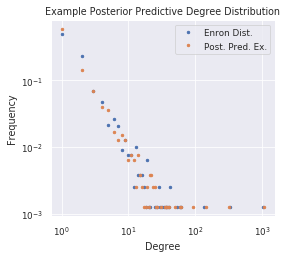

In [22]:
nodes, degrees = np.unique([r for interaction in pp_interactions for r in interaction[-1]],
                           return_counts=True)
pp_unique_degrees, pp_degree_counts = np.unique(degrees, return_counts=True)

nodes, degrees = np.unique([r for interaction in kaminsky_interactions for r in interaction[-1]],
                           return_counts=True)
unique_degrees, degree_counts = np.unique(degrees, return_counts=True)

fig, ax = plt.subplots(figsize=(4,4))
ax.loglog(unique_degrees, degree_counts / degree_counts.sum(), '.', label='Enron Dist.')
ax.loglog(pp_unique_degrees, pp_degree_counts / pp_degree_counts.sum(), '.', label='Post. Pred. Ex.')
ax.set_title('Example Posterior Predictive Degree Distribution')
ax.set_xlabel('Degree')
ax.set_ylabel('Frequency')
ax.legend()
ax.set_aspect('equal')
fig.savefig('example_post_pred_degree_dist.png', dpi=400)

In [23]:
true_interaction_time_by_rec = defaultdict(list)
for t, interaction_recs in kaminsky_interactions:
    for r in interaction_recs:
        true_interaction_time_by_rec[r].append(t)

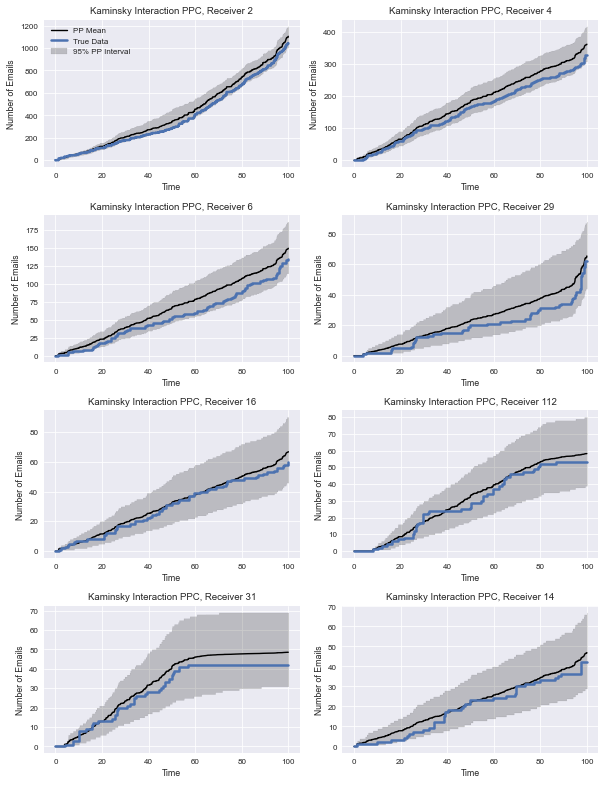

In [35]:
top8 = [2, 4, 6, 29, 16, 112, 31, 14]

fig, axs = plt.subplots(4, 2, figsize=(8.5,11))
for k, r in enumerate(top8):
    
    temp = true_interaction_time_by_rec[r]
    x = np.concatenate([[0], np.repeat(temp, 2), [kaminsky_interactions[-1][0]]])
    y = np.repeat(np.arange(0, len(temp)+1), 2)

    plots = []
    y_pps = []
    for interaction_time_by_rec in ppc_list:
        temp = interaction_time_by_rec[r]
        x_pp = np.concatenate([[0], np.repeat(temp, 2), [kaminsky_interactions[-1][0]]])
        y_pp = np.repeat(np.arange(0, len(temp)+1), 2)
        plots.append((x_pp, y_pp))
        y_pps.append(y_pp)
    
    i, j = np.unravel_index(k, (4, 2))
    
    axs[i, j].plot(kaminsky_interaction_times, ppc_mean_array[r, :], color='black', label='PP Mean')
    #axs[i, j].plot(kaminsky_interaction_times, ppc_alpha[r, :], color='black')
    #axs[i, j].plot(kaminsky_interaction_times, ppc_1alpha[r, :], color='black')
    axs[i, j].fill_between(kaminsky_interaction_times, 
                           ppc_alpha[r, :], 
                           ppc_1alpha[r, :], color='black', alpha=0.2, label='95% PP Interval')
    axs[i,j].plot(x, y, linewidth=2.5, label='True Data')
    axs[i,j].set_title('Kaminsky Interaction PPC, Receiver {}'.format(r))
    axs[i,j].set_ylabel('Number of Emails')
    axs[i,j].set_xlabel('Time')
    if i == 0 and j == 0:
        axs[i, j].legend()
fig.tight_layout()
fig.savefig('ppc.png')

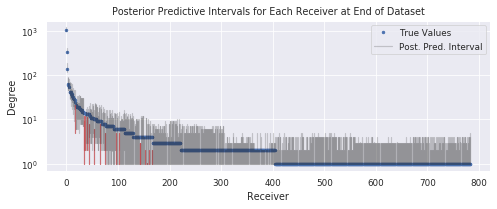

In [28]:
fig, ax = plt.subplots(figsize=(7,3))
true_values = np.array([len(true_interaction_time_by_rec[r]) for r in range(784)])
inds = true_values.argsort()[::-1]
ax.semilogy(true_values[inds], '.', label='True Values')
in_interval = (ppc_alpha[:-1, -1] <= true_values) & (ppc_1alpha[:-1, -1] >= true_values)

for i, r in enumerate(inds):
    if i == 0:
        ax.plot([i, i], [ppc_alpha[r, -1], ppc_1alpha[r, -1]], 
                color='k', alpha=0.2, label='Post. Pred. Interval')
    else:
        if in_interval[r]:
            ax.plot([i, i], [ppc_alpha[r, -1], ppc_1alpha[r, -1]], 
                    color='k', alpha=0.2)
        else:
            ax.plot([i, i], [ppc_alpha[r, -1], ppc_1alpha[r, -1]], 
                    color='r', alpha=0.8)
    
ax.set_xlabel('Receiver')
ax.set_ylabel('Degree')
ax.set_title('Posterior Predictive Intervals for Each Receiver at End of Dataset')
ax.legend()

#fig.tight_layout(rect=[0, 0, 1, 0.80])
fig.tight_layout()

fig.savefig('pp_rec_plot.pdf')
    

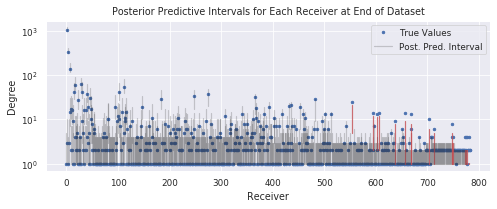

In [31]:
fig, ax = plt.subplots(figsize=(7,3))
true_values = np.array([len(true_interaction_time_by_rec[r]) for r in range(784)])
inds = true_values.argsort()[::-1]
ax.semilogy(true_values, '.', label='True Values')
in_interval = (ppc_alpha[:-1, -1] <= true_values) & (ppc_1alpha[:-1, -1] >= true_values)

for i, r in enumerate(range(num_recs)):
    if i == 0:
        ax.plot([i, i], [ppc_alpha[r, -1], ppc_1alpha[r, -1]], 
                color='k', alpha=0.2, label='Post. Pred. Interval')
    else:
        if in_interval[r]:
            ax.plot([i, i], [ppc_alpha[r, -1], ppc_1alpha[r, -1]], 
                    color='k', alpha=0.2)
        else:
            ax.plot([i, i], [ppc_alpha[r, -1], ppc_1alpha[r, -1]], 
                    color='r', alpha=0.8)
    
ax.set_xlabel('Receiver')
ax.set_ylabel('Degree')
ax.set_title('Posterior Predictive Intervals for Each Receiver at End of Dataset')
ax.legend()

#fig.tight_layout(rect=[0, 0, 1, 0.80])
fig.tight_layout()

fig.savefig('pp_rec_plot.pdf')

In [32]:
time_to_ind_dict = {t: i for i, t in enumerate(kaminsky_interaction_times)}
true_cum_array = np.zeros((784, len(time_to_ind_dict)))
for r in range(785):
    for t in true_interaction_time_by_rec[r]:
        true_cum_array[r, time_to_ind_dict[t]] += 1
    #x = np.concatenate([[0], np.repeat(temp, 2), [kaminsky_interactions[-1][0]]])
    #y = np.repeat(np.arange(0, len(temp)+1), 2)
true_cum_array = np.cumsum(true_cum_array, axis=1)
                          # ((ppc_alpha[:-1, -1] <= true_values) & (ppc_1alpha[:-1, -1] >= true_values)).sum() / 784

In [39]:
((ppc_alpha[:-1, :] <= true_cum_array) & 
 (ppc_1alpha[:-1, :] >= true_cum_array)).sum() / 784 / 4192

0.9907254707703692

In [33]:
((ppc_alpha[:-1, -1] <= true_values) & (ppc_1alpha[:-1, -1] >= true_values)).sum() / 784

0.9719387755102041

In [37]:
ct_datetimes = [datetime.datetime.fromtimestamp(t) for t in (times * (max_time - min_time) / 100 + min_time) * 1e-9]
#ct_datetimes = [datetime.datetime.fromtimestamp(t) for t in times * 1e-9]

In [38]:
times

array([0.00000000e+00, 2.63335431e-02, 2.75337827e-02, ...,
       9.99728006e+01, 9.99755036e+01, 9.99827554e+01])

NameError: name 'probs' is not defined

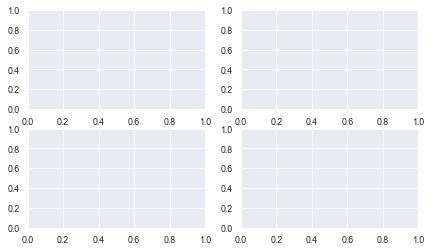

In [22]:
fig, axs = plt.subplots(2,2, figsize=(7, 4))
r = 2
utils.plot_teem_posterior_plot(probs[:, r], probs_ul[:, r], probs_ll[:, r], ct_datetimes, datetimes[-1],
                               plot_events=False, ax=axs[0, 0], legend=False)
axs[0, 0].legend(fontsize=8)
axs[0, 0].set_ylabel('Receiver 2 Probability')

temp = true_interaction_time_by_rec[r]
x = np.concatenate([[0], np.repeat(temp, 2), [kaminsky_interactions[-1][0]]])
y = np.repeat(np.arange(0, len(temp)+1), 2)
x_dates = np.array([time_dict[t] for t in x])
k_dates = np.array([time_dict[t] for t in kaminsky_interaction_times])
axs[1, 0].plot(x_dates, y, linewidth=2.5, label='True Data')
axs[1, 0].plot(k_dates, ppc_mean_array[r, :], color='black', label='Post. Pred. Mean')
axs[1, 0].fill_between(k_dates, ppc_alpha[r, :], ppc_1alpha[r, :], 
                       color='black', alpha=0.2, label='95% Post. Pred. Interval')
axs[1, 0].set_ylabel('Number of Emails')
axs[1, 0].legend(fontsize=8)
r = 31
utils.plot_teem_posterior_plot(probs[:, r], probs_ul[:, r], probs_ll[:, r], ct_datetimes, datetimes[-1],
                               plot_events=False, ax=axs[0, 1], legend=False)
axs[0, 1].set_ylabel('Receiver 31 Probability')

temp = true_interaction_time_by_rec[r]
x = np.concatenate([[0], np.repeat(temp, 2), [kaminsky_interactions[-1][0]]])
y = np.repeat(np.arange(0, len(temp)+1), 2)
x_dates = np.array([time_dict[t] for t in x])
k_dates = np.array([time_dict[t] for t in kaminsky_interaction_times])
axs[1, 1].plot(x_dates, y, linewidth=2.5, label='True Data')
axs[1, 1].plot(k_dates, ppc_mean_array[r, :], color='black', label='Post. Pred. Mean')
axs[1, 1].fill_between(k_dates, ppc_alpha[r, :], ppc_1alpha[r, :], 
                       color='black', alpha=0.2, label='95% Post. Pred. Interval')
axs[1, 1].set_ylabel('Number of Emails')
#axs[0, 1].legend(fontsize=8)

fig.suptitle('Posterior Probabilities (Top) and \n Posterior Predictive Intervals for Cumulative Emails (Bottom)')
fig.tight_layout(rect=[0, 0, 1, 0.90])

In [40]:
fig.savefig('kaminsky_ind_rec_results.png', dpi=1000)

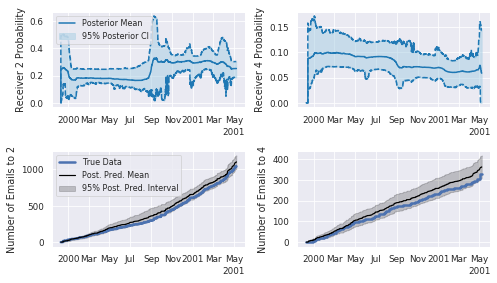

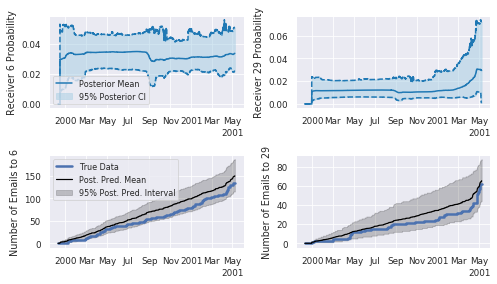

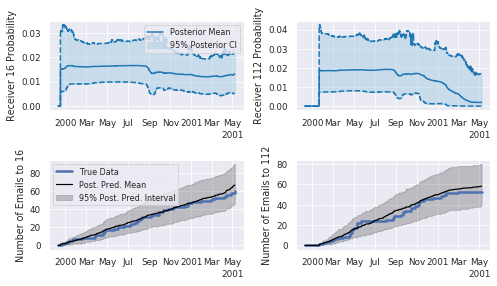

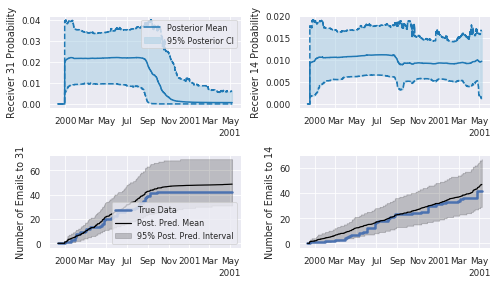

In [57]:
#fig, axs = plt.subplots(2,2, figsize=(7, 4))
plot_recs = [2, 4, 6, 29, 16, 112, 31, 14]

for p in range(4):
    r1 = plot_recs[2 * p]
    r2 = plot_recs[2 * p + 1]
    fig, axs = plt.subplots(2,2, figsize=(7, 4))
    utils.plot_teem_posterior_plot(probs[:, r1], probs_ul[:, r1], probs_ll[:, r1], ct_datetimes, datetimes[-1],
                               plot_events=False, ax=axs[0, 0], legend=False)
    axs[0, 0].legend(fontsize=8)
    axs[0, 0].set_ylabel('Receiver {} Probability'.format(r1))

    temp = true_interaction_time_by_rec[r1]
    x = np.concatenate([[0], np.repeat(temp, 2), [kaminsky_interactions[-1][0]]])
    y = np.repeat(np.arange(0, len(temp)+1), 2)
    x_dates = np.array([time_dict[t] for t in x])
    k_dates = np.array([time_dict[t] for t in kaminsky_interaction_times])
    axs[1, 0].plot(x_dates, y, linewidth=2.5, label='True Data')
    axs[1, 0].plot(k_dates, ppc_mean_array[r1, :], color='black', label='Post. Pred. Mean')
    axs[1, 0].fill_between(k_dates, ppc_alpha[r1, :], ppc_1alpha[r1, :], 
                       color='black', alpha=0.2, label='95% Post. Pred. Interval')
    axs[1, 0].set_ylabel('Number of Emails to {}'.format(r1))
    axs[1, 0].legend(fontsize=8)

    utils.plot_teem_posterior_plot(probs[:, r2], probs_ul[:, r2], probs_ll[:, r2], ct_datetimes, datetimes[-1],
                               plot_events=False, ax=axs[0, 1], legend=False)
    axs[0, 1].set_ylabel('Receiver {} Probability'.format(r2))

    temp = true_interaction_time_by_rec[r2]
    x = np.concatenate([[0], np.repeat(temp, 2), [kaminsky_interactions[-1][0]]])
    y = np.repeat(np.arange(0, len(temp)+1), 2)
    x_dates = np.array([time_dict[t] for t in x])
    k_dates = np.array([time_dict[t] for t in kaminsky_interaction_times])
    axs[1, 1].plot(x_dates, y, linewidth=2.5, label='True Data')
    axs[1, 1].plot(k_dates, ppc_mean_array[r2, :], color='black', label='Post. Pred. Mean')
    axs[1, 1].fill_between(k_dates, ppc_alpha[r2, :], ppc_1alpha[r2, :], 
                       color='black', alpha=0.2, label='95% Post. Pred. Interval')
    axs[1, 1].set_ylabel('Number of Emails to {}'.format(r2))
#axs[0, 1].legend(fontsize=8)
    fig.tight_layout()
    fig.savefig('top_recs{}.pdf'.format(p))
        
#fig.suptitle('Posterior Probabilities (Top) and \n Posterior Predictive Intervals for Cumulative Emails (Bottom)')
#fig.tight_layout(rect=[0, 0, 1, 0.90])

In [43]:
unique_receivers, receiver_count = np.unique([r for [t, recs] in kaminsky_interactions for r in recs], return_counts=True)
degree_dict = {k: v for (k, v) in zip(unique_receivers, receiver_count)}
receiver_count = np.concatenate([receiver_count, [0]])

In [44]:
np.sum(receiver_count > 1)

405

In [45]:
time_to_ind_dict = {t: i for i, t in enumerate(kaminsky_interaction_times)}

In [46]:
pp_save_dirs[127]

PosixPath('/home/boselio/Dropbox/teem/experiments/kaminsky_experiment_modified/pp_data/0/127.dat')

In [47]:
#Chi Square test (per receiver, then summed)
#Calculate the discrepancy measure for each theta_j, between y_rep and original y.
pp_save_dir = save_dir / 'pp_data'
num_chains = 4
num_iters = 250

pp_save_dirs = [pp_save_dir / '{}'.format(c) / '{}.dat'.format(i) 
                for c in range(num_chains)
                for i in range(num_iters)]

save_dirs = [save_dir / '{}'.format(c) / '{}.pkl'.format(i) 
                for c in range(num_chains)
                for i in range(num_iters)]


y_cumulative = np.zeros((num_recs, len(kaminsky_interaction_times)))
for i, (t, rec_list) in enumerate(kaminsky_interactions):
        for r in rec_list:
            y_cumulative[r, i] += 1

y_cumulative = np.cumsum(y_cumulative, axis=1)

d_yrep_array = np.zeros((len(save_dirs), y_cumulative.shape[-1]))
d_y_array = np.zeros((len(save_dirs), y_cumulative.shape[-1]))
d_y_final = np.zeros((len(save_dirs), num_recs))
d_yrep_final = np.zeros((len(save_dirs), num_recs))
nks_yrep = np.zeros((len(save_dirs), num_recs ))
nks_y = np.zeros((len(save_dirs), num_recs))
mean_nks_yrep = np.zeros((len(save_dirs), num_recs))
mean_nks_y = np.zeros((len(save_dirs), num_recs))

for i, (sd, ppsd) in enumerate(zip(save_dirs, pp_save_dirs)):
    if i % 100 == 0:
         print(i)
    pp_interactions = utils.load_interactions(ppsd)
    
    with sd.open('rb') as infile:
        temporal_probs, params = pickle.load(infile)
        
    stick_list = []
    for r in range(num_recs):
        sticks_ind = np.digitize(kaminsky_interaction_times, 
                                 temporal_probs.arrival_times_dict[r], right=True) - 1

        #sticks_ind[sticks_ind == len(tp.stick_dict[r])] = len(tp.stick_dict[r]) - 1
        #Need to take into account 
        sticks = np.array(temporal_probs.stick_dict[r])[sticks_ind]
        sticks[kaminsky_interaction_times <= temporal_probs.created_times[r]] = 0
        #sticks[kaminsky_interaction_times <= temporal_probs.created_times[r]] = 1
        sticks[sticks_ind == -1] = 1
        stick_list.append(sticks)

    stick_array = np.array(stick_list)
    #probs_array = np.vstack([stick_array, np.ones(stick_array.shape[1])])
    probs_array = stick_array.copy()
    probs_array[1:, :] = probs_array[1:, :] * np.cumprod(1 - probs_array[:-1, :], axis=0)
    for r, ct in enumerate(temporal_probs.created_times):
        created_ind = np.where(kaminsky_interaction_times == ct)[0]
        probs_array[:, created_ind] = 0.0
        probs_array[r, created_ind] = 1.0
    probs_sum = probs_array.sum(axis=0)
    probs_array = probs_array / probs_sum
    
    cum_prob_array = np.cumsum(probs_array, axis=1)
    var_array = probs_array * (1 - probs_array)
    var_array = np.cumsum(var_array, axis=1)
    y_rep_cumulative = np.zeros_like(cum_prob_array)
    for ii, (t, rec_list) in enumerate(pp_interactions):
        for r in rec_list:
            y_rep_cumulative[r, ii] += 1


    y_rep_cumulative = np.cumsum(y_rep_cumulative, axis=1)

    discrepancy = np.zeros_like(y_rep_cumulative)
    y_size = y_cumulative.shape
    
    normalized_ks_all = np.zeros_like(y_rep_cumulative)
    mask = (var_array != 0)
    normalized_ks_all[mask] = np.abs(y_rep_cumulative[mask] - cum_prob_array[mask]) / cum_prob_array[mask]
    normalized_ks = np.max(normalized_ks_all, axis=1)
    nks_yrep[i, :] = normalized_ks
    mean_nks_yrep[i, :] = normalized_ks_all.mean(axis=1)
    
    normalized_ks_all[mask] = np.abs(y_cumulative[mask] - cum_prob_array[mask]) / cum_prob_array[mask]
    normalized_ks = np.max(normalized_ks_all, axis=1)
    nks_y[i, :] = normalized_ks
    mean_nks_y[i, :] = normalized_ks_all.mean(axis=1)
    #Masking all receiver counts that only have 1 degree
    
    #mask[receiver_count <= 1, :] = False
    
    #discrepancy[mask] = (y_rep_cumulative[mask] - cum_prob_array[mask])**2 / var_array[mask]
    discrepancy[mask] = (y_rep_cumulative[mask] - cum_prob_array[mask])**2
    
    
    #d_yrep_list_max_rec.append(discrepancy[669,:])
    d_yrep_final[i, :] = discrepancy[:, -1]
    discrepancy = discrepancy.sum(axis=0)
    d_yrep_array[i, :] = discrepancy
    
    discrepancy = np.zeros_like(y_cumulative)
    #discrepancy[mask] = (y_cumulative[mask] - cum_prob_array[mask])**2 / var_array[mask]
    discrepancy[mask] = (y_cumulative[mask] - cum_prob_array[mask])**2 
    #d_y_list_max_rec.append(discrepancy[669,:])
    d_y_final[i, :] = discrepancy[:, -1]
    discrepancy = discrepancy.sum(axis=0)
    d_y_array[i, :] = discrepancy

0
100
200
300
400
500
600
700
800
900


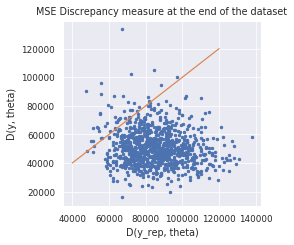

In [58]:
fig, ax = plt.subplots(figsize=(4,3.5))
ax.plot(d_yrep_array[:, -1], d_y_array[:, -1], '.')
ax.set_ylabel('D(y, theta)')
ax.set_xlabel('D(y_rep, theta)')
ax.set_title('MSE Discrepancy measure at the end of the dataset')
ax.plot([40000, 120000], [40000, 120000])
#ax.set_aspect('square')
fig.tight_layout()
fig.savefig('mse_discrepancy_scatterplot.pdf')


In [68]:
(d_yrep_array[:, -1] > d_y_array[:, -1]).mean()

0.953

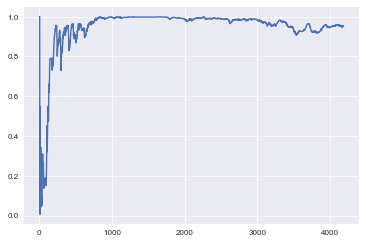

In [70]:
plt.plot((d_yrep_array >= d_y_array).mean(axis=0))

In [50]:
p_b_by_node = (d_yrep_final > d_y_final).mean(axis=0)

In [54]:
sorted_p_b_by_node = np.sort(p_b_by_node)

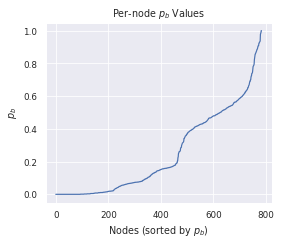

In [59]:
fig, ax = plt.subplots(figsize=(4, 3.5))
ax.plot(sorted_p_b_by_node)
ax.set_ylabel(r'$p_b$')
ax.set_xlabel('Nodes (sorted by $p_b$)')
ax.set_title(r'Per-node $p_b$ Values')
fig.tight_layout()
fig.savefig('mse_per_rec_pb.pdf')

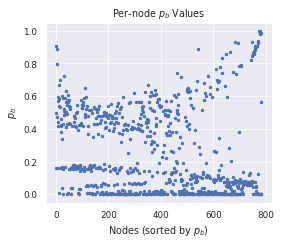

In [53]:
fig, ax = plt.subplots(figsize=(4, 3.5))
ax.plot(p_b_by_node, '.')
ax.set_ylabel(r'$p_b$')
ax.set_xlabel('Nodes (sorted by $p_b$)')
ax.set_title(r'Per-node $p_b$ Values')
fig.tight_layout()
#fig.savefig('mse_per_rec_pb.png')

In [56]:
(sorted_p_b_by_node > 0.05).mean()

0.6862244897959183

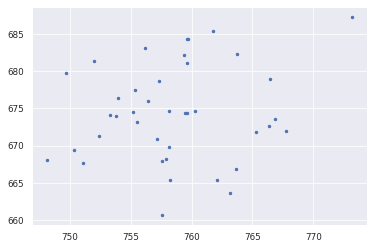

In [219]:
plt.plot(nks_y.sum(axis=1), nks_yrep.sum(axis=1), '.')
#plt.plot([1500, 1700], [1500, 1700])

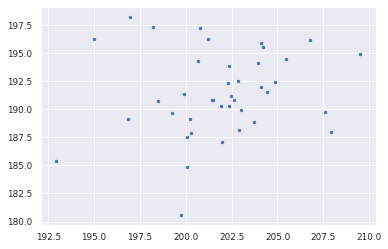

In [220]:
plt.plot(mean_nks_y.sum(axis=1), mean_nks_yrep.sum(axis=1), '.')
#plt.plot([1500, 1700], [1500, 1700])
#plt.plot([200, 400], [200, 400])

In [221]:
(nks_y.sum(axis=1) < nks_yrep.sum(axis=1)).sum() / len(nks_yrep.sum(axis=1))

0.0

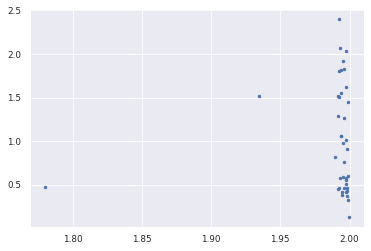

In [223]:
plt.plot(nks_y[:, 5], nks_yrep[:, 5], '.')
#plt.plot([0.3, 1.7], [0.3, 1.7])

In [41]:
(nks_y[:, 2] < nks_yrep[:, 2]).sum() / 1000

0.03

In [36]:
p_b_nks = (nks_y < nks_yrep).mean(axis=0)

0.5216836734693877

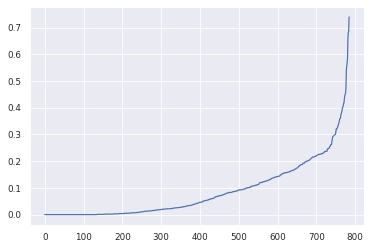

In [37]:
p_b_nks_sorted = np.sort(p_b_nks)
plt.plot(p_b_nks_sorted)
(p_b_nks <= 0.05).sum() / 784

In [38]:
p_b_mnks = (mean_nks_y < mean_nks_yrep).mean(axis=0)

0.26403061224489793

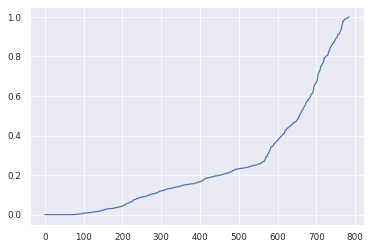

In [39]:
p_b_mnks_sorted = np.sort(p_b_mnks)
plt.plot(p_b_mnks_sorted)
(p_b_mnks <= 0.05).sum() / 784

In [40]:
np.where(p_b_nks <= 0.05)

(array([  2,   5,   7,  12,  16,  18,  19,  20,  25,  26,  27,  32,  42,
         43,  45,  46,  47,  48,  53,  58,  59,  61,  86,  90,  95, 102,
        103, 110, 118, 119, 122, 125, 126, 138, 139, 140, 142, 144, 145,
        148, 151, 155, 156, 160, 161, 162, 165, 166, 168, 170, 171, 175,
        176, 177, 178, 180, 183, 185, 186, 189, 190, 194, 195, 196, 198,
        200, 201, 203, 205, 209, 212, 215, 217, 218, 220, 228, 230, 231,
        233, 235, 237, 238, 239, 241, 243, 244, 247, 250, 252, 253, 254,
        255, 256, 257, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 272, 273, 274, 275, 277, 278, 280, 281, 282, 285, 286, 288,
        291, 296, 298, 300, 301, 302, 304, 306, 307, 308, 309, 310, 312,
        314, 316, 317, 319, 325, 327, 331, 332, 338, 339, 342, 343, 344,
        346, 347, 348, 349, 351, 352, 353, 358, 359, 360, 362, 363, 364,
        366, 367, 368, 369, 370, 372, 376, 377, 378, 380, 383, 386, 388,
        391, 392, 393, 394, 395, 396, 400, 401, 402

In [49]:
np.where(p_b_mnks <= 0.05)

(array([ 12,  26,  43,  45,  58,  86,  90, 140, 148, 151, 170, 178, 180,
        183, 194, 195, 196, 198, 203, 205, 209, 212, 220, 230, 238, 239,
        243, 244, 250, 254, 255, 259, 262, 267, 268, 269, 272, 274, 275,
        280, 281, 286, 288, 291, 296, 301, 302, 309, 316, 332, 338, 342,
        348, 353, 362, 366, 370, 377, 386, 388, 395, 396, 400, 401, 403,
        404, 405, 413, 422, 445, 446, 452, 455, 466, 471, 472, 478, 483,
        485, 487, 489, 490, 492, 493, 503, 508, 510, 513, 518, 521, 523,
        524, 525, 544, 546, 547, 550, 552, 553, 559, 568, 570, 578, 580,
        585, 590, 593, 595, 597, 598, 599, 602, 612, 620, 627, 629, 630,
        631, 632, 636, 637, 639, 641, 646, 647, 653, 654, 655, 656, 658,
        663, 666, 668, 669, 678, 679, 683, 685, 686, 689, 690, 691, 696,
        697, 699, 700, 701, 703, 704, 706, 707, 709, 710, 711, 712, 713,
        714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726,
        727, 728, 729, 730, 731, 732, 734, 735, 736

In [50]:
d_y_final.shape, d_yrep_final.shape

((200, 785), (200, 785))

Text(0.5, 1.0, 'Discrepancy measure at the end of the dataset')

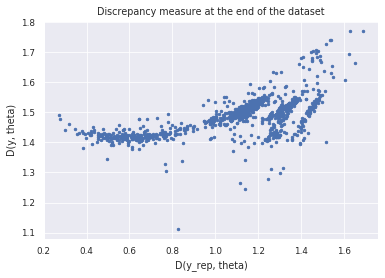

In [204]:
i = 9
plt.plot(d_yrep_array[:, i], d_y_array[:, i], '.')
plt.ylabel('D(y, theta)')
plt.xlabel('D(y_rep, theta)')
plt.title('Discrepancy measure at the end of the dataset')
#plt.plot([0, 4000], [0, 4000])

In [186]:
d_yrep_array[:, 3].shape

(1000,)

In [199]:
d_yrep_array[:, 7] >= d_y_array[:, 7]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False,

In [198]:
(d_yrep_array >= d_y_array).mean(axis=0)[:20]

array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.006, 0.006,
       0.006, 0.006, 0.006, 0.006, 0.547, 0.186, 0.186, 0.186, 0.186,
       0.186, 0.314])

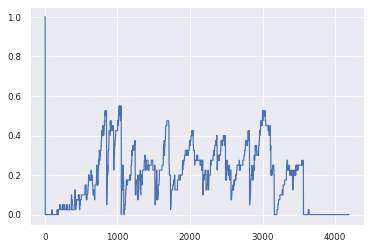

In [217]:
plt.plot((d_yrep_array >= d_y_array).mean(axis=0))

In [147]:
d_y_array[:, -1]

array([62538.71462452, 38176.51353069, 72137.25782741, 39585.55866456,
       48602.75362454, 47365.99163904, 52585.09420206, 48539.43417176,
       57227.13551427, 47605.48991777, 37616.69012019, 44852.45358071,
       39384.02301072, 75208.88708617, 44861.44993212, 48116.73844604,
       56719.91300501, 73598.63634894, 51004.41792733, 49366.97929023,
       35279.89853425, 39891.53289683, 85440.28242323, 76146.73906176,
       49059.11498322, 49564.740726  , 50322.95803214, 57599.85163869,
       52805.1354044 , 39475.98485554, 44118.35313757, 42002.1862496 ,
       53305.82255417, 48035.4362558 , 63954.37631785, 37296.30784817,
       32746.84030977, 46710.65318742, 69977.08107519, 53451.1555142 ,
       46880.11613471, 73766.19284865, 39027.01137869, 51245.14570377,
       54956.90436674, 66664.69586165, 44530.21233216, 38220.77157347,
       49553.93222578, 79787.60174718, 45807.30652704, 54537.26921778,
       76889.47348553, 61079.24108986, 33602.52474816, 54820.52047661,
      

Text(0.5, 1.0, 'Discrepancy measure at the end of the dataset')

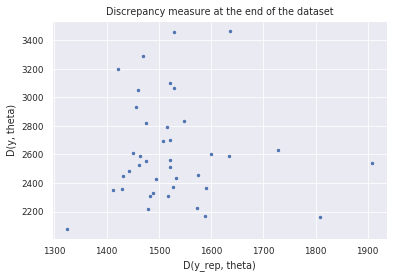

In [207]:
plt.plot(d_yrep_array[:, -1], d_y_array[:, -1], '.')
plt.ylabel('D(y, theta)')
plt.xlabel('D(y_rep, theta)')
plt.title('Discrepancy measure at the end of the dataset')
#plt.plot([20000, 100000], [20000, 100000])
#plt.savefig('discrepancy_scatterplot.png')

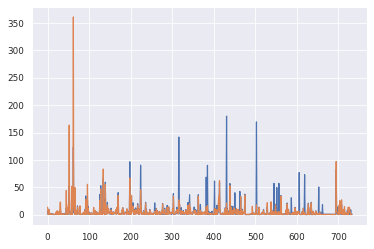

In [215]:
plt.plot(d_y_final.mean(axis=0)[50:])
plt.plot(d_yrep_final.mean(axis=0)[50:])

In [104]:
 len(d_y_array[:, -1])

1000

In [148]:
(d_yrep_array[:, -1] > d_y_array[:, -1]).sum() / len(d_y_array[:, -1])

1.0

In [105]:
p_b_by_node = (d_yrep_final > d_y_final).sum(axis=0) / 1000

In [106]:
p_b_by_node = (d_yrep_final[:, :-1][:, degrees >= 2] > d_y_final[:, :-1][:, degrees >= 2]).sum(axis=0) / len((d_yrep_final[:, :-1][:, degrees >= 2] > d_y_final[:, :-1][:, degrees >= 2]).sum(axis=0))

In [107]:
p_b_by_node_sorted = np.sort(p_b_by_node)

In [108]:
(p_b_by_node <= 0.05).sum()

29

In [109]:
np.where(p_b_by_node <= 0.05)

(array([  8,  85, 103, 125, 141, 144, 146, 153, 154, 172, 203, 224, 268,
        269, 270, 278, 281, 289, 292, 303, 304, 305, 309, 312, 314, 316,
        317, 320, 327]),)

In [110]:
np.median(d_y_final, axis=0)[2],  np.median(d_yrep_final, axis=0)[2]

(817.0876763571666, 6809.747423115246)

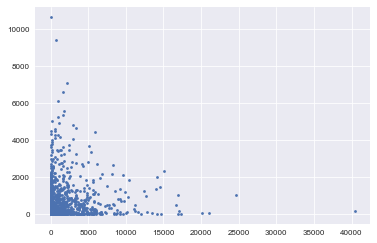

In [127]:
plt.plot(d_y_final[:, 2], d_yrep_final[:, 2], '.')

In [128]:
degrees[((d_y_final.mean(axis=0)[:-1] - d_yrep_final.mean(axis=0)[:-1]) / d_yrep_final.mean(axis=0)[:-1]).argsort()[::-1]]

/Users/boselio/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([   2,    1,    2,    1,    1,    2,    1,    2,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    2,
          1,    2,    1,    2,    1,    1,    1,    1,    1,    1,    2,
          1,    2,    2,    2,    1,    1,    2,    1,    2,    1,    2,
          1,    1,    2,    1,    2,    1,    1,    1,    2,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    2,    1,    1,    1,
          2,    1,    1,    1,    1,    1,    1,    1,    2,    1,    2,
          2,    1,    2,    1,    1,    1,    1,    1,    2,    2,    1,
          1,    2,    2,    2,    1,    2,    2,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    2,    2,    2,    2,    2,    2,
          1,    1,    2,    1,    1,    1,    2,    2,    1,    1,    1,
          1,    2,    1,    1,    2,    2,    1,    1,    2,    1,    1,
          2,    1,    2,    2,    2,    1,    2,    1,    1,    1,    1,
          2,    1,    1,    1,    1,    1,    1,   

In [129]:
((d_y_final.mean(axis=0) - d_yrep_final.mean(axis=0)) / d_yrep_final.mean(axis=0)).argsort()[::-1]

/Users/boselio/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([784, 311, 321, 319, 316, 315, 314, 313, 312, 309, 296, 306, 305,
       304, 303, 302, 301, 300, 322, 323, 324, 325, 349, 348, 346, 344,
       343, 342, 340, 338, 337, 336, 335, 333, 332, 330, 329, 299, 295,
       244, 259, 267, 266, 265, 263, 262, 261, 260, 258, 293, 256, 255,
       254, 252, 251, 250, 249, 268, 269, 270, 272, 291, 290, 289, 288,
       287, 286, 285, 284, 283, 280, 279, 277, 276, 275, 273, 352, 353,
       354, 434, 445, 444, 443, 441, 440, 439, 437, 433, 356, 431, 429,
       427, 426, 425, 424, 423, 447, 448, 449, 450, 473, 472, 471, 470,
       469, 467, 464, 462, 460, 459, 457, 456, 455, 454, 453, 422, 421,
       419, 783, 389, 388, 387, 385, 384, 379, 377, 374, 373, 371, 370,
       365, 364, 362, 357, 390, 393, 417, 395, 416, 415, 414, 413, 411,
       410, 409, 408, 406, 405, 404, 401, 400, 399, 398, 246, 243, 475,
        86,  93,  92,  91,  90,  89,  88,  87,  85,  72,  84,  83,  82,
        79,  78,  77,  75,  94,  96,  99, 104, 129, 127, 126, 12

Text(0.5, 1.0, 'Sorted per node p-values')

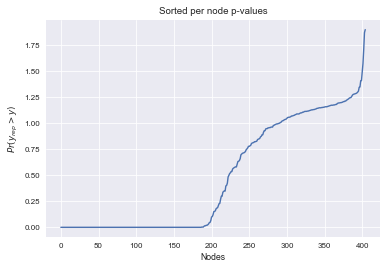

In [130]:
plt.plot(p_b_by_node_sorted)
plt.xlabel('Nodes')
plt.ylabel(r'$Pr(y_{rep} > y)$')
plt.title('Sorted per node p-values')

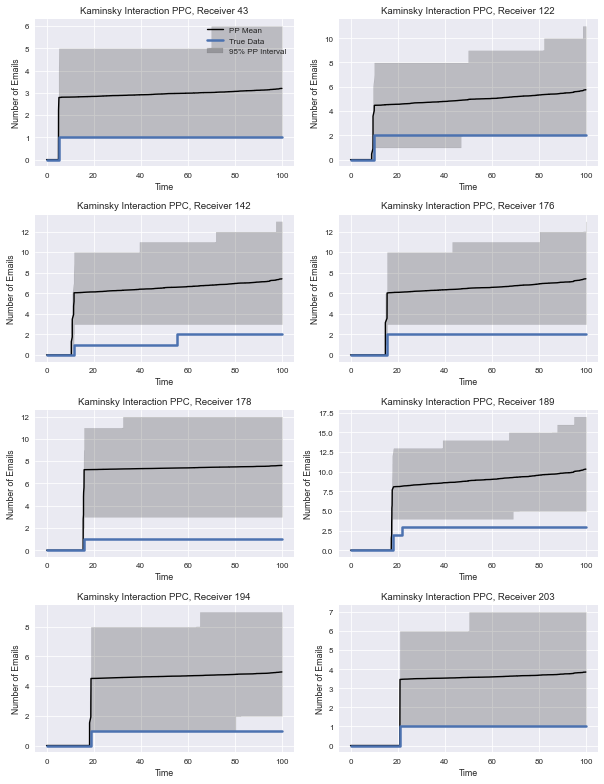

In [191]:
top8 = [43, 122, 142, 176, 178, 189, 194, 203]

fig, axs = plt.subplots(4, 2, figsize=(8.5,11))
for k, r in enumerate(top8):
    
    temp = true_interaction_time_by_rec[r]
    x = np.concatenate([[0], np.repeat(temp, 2), [kaminsky_interactions[-1][0]]])
    y = np.repeat(np.arange(0, len(temp)+1), 2)

    plots = []
    y_pps = []
    for interaction_time_by_rec in ppc_list:
        temp = interaction_time_by_rec[r]
        x_pp = np.concatenate([[0], np.repeat(temp, 2), [kaminsky_interactions[-1][0]]])
        y_pp = np.repeat(np.arange(0, len(temp)+1), 2)
        plots.append((x_pp, y_pp))
        y_pps.append(y_pp)
    
    i, j = np.unravel_index(k, (4, 2))
    
    axs[i, j].plot(kaminsky_interaction_times, ppc_mean_array[r, :], color='black', label='PP Mean')
    #axs[i, j].plot(kaminsky_interaction_times, ppc_alpha[r, :], color='black')
    #axs[i, j].plot(kaminsky_interaction_times, ppc_1alpha[r, :], color='black')
    axs[i, j].fill_between(kaminsky_interaction_times, 
                           ppc_alpha[r, :], 
                           ppc_1alpha[r, :], color='black', alpha=0.2, label='95% PP Interval')
    axs[i,j].plot(x, y, linewidth=2.5, label='True Data')
    axs[i,j].set_title('Kaminsky Interaction PPC, Receiver {}'.format(r))
    axs[i,j].set_ylabel('Number of Emails')
    axs[i,j].set_xlabel('Time')
    if i == 0 and j == 0:
        axs[i, j].legend()
fig.tight_layout()

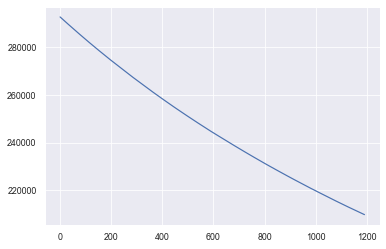

In [71]:
plt.plot(d_yrep_array[127, 3000:])

In [69]:
d_yrep_array.shape

(400, 4192)

In [76]:
d_yrep_array[127, -1]

209845.27669146724

In [114]:
(d_yrep_array[:, -1] > d_y_array[:, -1]).sum() / len(d_y_array[:, -1])

0.07532467532467532

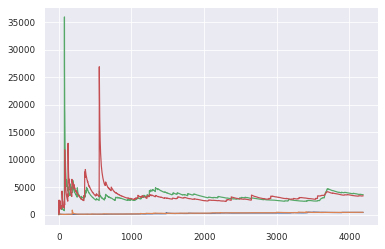

In [78]:
plt.plot(d_yrep_array[0, :])
plt.plot(d_yrep_array[1, :])
plt.plot(d_y_array[1, :])
plt.plot(d_y_array[0, :])

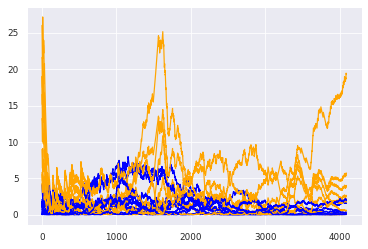

In [79]:
for i in range(10):
    plt.plot(d_yrep_max_rec_array[i, 100:], color='blue')
    plt.plot(d_y_max_rec_array[i, 100:], color='orange')

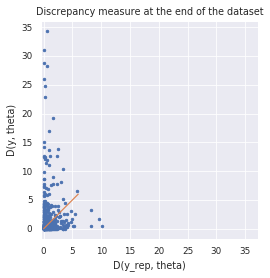

In [80]:
plt.plot(d_yrep_max_rec_array[:, -1], d_y_max_rec_array[:, -1], '.')
plt.plot([0, 6], [0, 6])
plt.axis('square')
plt.ylabel('D(y, theta)')
plt.xlabel('D(y_rep, theta)')
plt.title('Discrepancy measure at the end of the dataset')
plt.savefig('discrepancy_scatterplot_max_rec.png')

In [81]:
np.sum(d_yrep_max_rec_array[:, -1] > d_y_max_rec_array[:, -1]) / 385

0.37922077922077924

In [82]:
d_yrep_array[384, :10]

array([   0.        , 1664.94070131,  832.13572218,  555.65309514,
        416.19314716,  331.91960695,  277.79814932,  239.7078303 ,
        208.71258434,  185.42149606])

In [83]:
cum_prob_array[r,:]

array([ 0.        ,  0.        ,  0.        , ..., 16.16272174,
       16.16882078, 16.17491983])

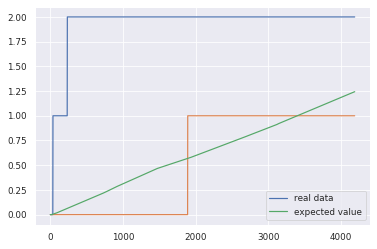

In [84]:
r = 19
plt.plot(y_cumulative[r,:], label='real data')
plt.plot(y_rep_cumulative[r,:])
plt.plot(cum_prob_array[r,:], label='expected value')
plt.legend()

In [85]:
temporal_probs.arrival_times_dict[19]

[1.2718248858132175]

In [86]:
probs_array[19, :200], 

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00022879, 0.00022879, 0.00022879,
        0.00022879, 0.00022879, 0.00022879, 0.00022879, 0.00022879,
        0.00022879, 0.00022879, 0.00022879, 0.00022879, 0.00022879,
        0.00022879, 0.00022879, 0.00022879, 0.00022879, 0.00022879,
        0.00022879, 0.00022879, 0.00022879, 0.00022879, 0.00022879,
        0.00022879, 0.00022879, 0.00022879, 0.00022879, 0.00022879,
        0.00022879, 0.00022879, 0.00022879, 0.00022879, 0.00022879,
        0.00022879, 0.00022879, 0.00022879, 0.00022879, 0.00022879,
        0.00022879, 0.00022879, 0.00022879, 0.00022879, 0.00022879,
        0.00022879, 0.00022879, 0.00022879, 0.00022879, 0.00022879,
        0.00022879, 0.00022879, 0.00022879, 0.00022879, 0.00022879,
        0.00022879, 0.00022879, 0.00022879, 0.00

In [87]:
discrepancy_yrep = np.zeros_like(y_rep_cumulative)
mask = (cum_prob_array != 0)

#Masking all receiver counts that only have 1 degree
mask[receiver_count <= 10, :] = False

discrepancy_yrep[mask] = (y_rep_cumulative[mask] - cum_prob_array[mask])**2 / var_array[mask]
#d_yrep_list_max_rec.append(discrepancy[2,:])
#discrepancy = discrepancy.sum(axis=0)
#d_yrep_list.append(discrepancy)

discrepancy_y = np.zeros_like(y_cumulative)
discrepancy_y[mask] = (y_cumulative[mask] - cum_prob_array[mask])**2 / var_array[mask]
#d_y_list_max_rec.append(discrepancy[2,:])
#discrepancy = discrepancy.sum(axis=0)
#d_y_list.append(discrepancy)

Text(0.5, 1.0, 'Receiver Comparison of discrepancies (One Sample)')

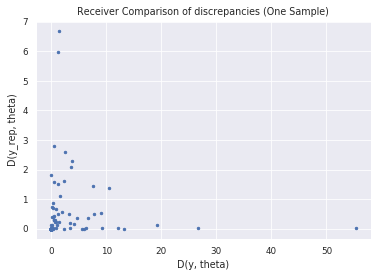

In [88]:
plt.plot(discrepancy_y[:, -1], discrepancy_yrep[:, -1], '.')
plt.xlabel('D(y, theta)')
plt.ylabel('D(y_rep, theta)')
plt.title('Receiver Comparison of discrepancies (One Sample)')

In [89]:
np.argsort(discrepancy_y[:, -1])[::-1]

array([669, 367, 308, 418,  48, 553, 602, 383, 435, 656, 458, 366,  23,
        11,  29, 607, 274, 116,   4,  46, 501, 341, 432,   7, 100, 102,
       481, 112, 146, 513, 368, 217,  39,   2, 113, 108,  16,  38,   6,
       392,  95, 595,  41, 403, 165,  14, 452,   9,  31, 184, 463,  35,
       248, 219, 220, 273, 221, 271, 222, 272, 270, 223, 269, 268, 224,
       267, 231, 277, 275, 276, 288, 287, 286, 213, 285, 284, 283, 214,
       282, 281, 215, 216, 280, 279, 278, 218, 265, 266, 262, 264, 239,
       227, 244, 243, 242, 241, 228, 240, 238, 225, 237, 229, 236, 235,
       230, 234, 233, 289, 246, 226, 247, 263, 232, 261, 260, 259, 258,
       257, 256, 255, 254, 253, 252, 251, 250, 249, 245, 302, 290, 291,
       356, 355, 354, 353, 352, 351, 350, 349, 348, 347, 346, 345, 344,
       343, 342, 340, 339, 338, 337, 357, 358, 359, 373, 381, 380, 379,
       378, 377, 376, 375, 374, 372, 360, 371, 370, 369, 365, 364, 363,
       362, 361, 336, 335, 334, 301, 310, 309, 307, 306, 305, 30

In [90]:
d_y_array.shape, d_yrep_array.shape

((385, 4192), (385, 4192))

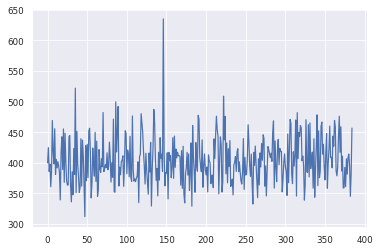

In [91]:
#plt.plot(d_y_array[:, -1])
plt.plot(d_yrep_array[:, -1])

In [48]:
interaction_time_by_rec = defaultdict(list)
for t, interaction_recs in pp_interactions:
    for r in interaction_recs:
        interaction_time_by_rec[r].append(t)

temp = interaction_time_by_rec[6]
x_pp = np.concatenate([[0], np.repeat(temp, 2), [kaminsky_interactions[-1][0]]])
y_pp = np.repeat(np.arange(0, len(temp)+1), 2)
plots.append((x_pp, y_pp))
if i % 50 == 0:
    print('Chain: {}, Iter: {}'.format(chain, i))

NameError: name 'i' is not defined

In [ ]:
create_pp_dataset()

In [47]:
[len(interaction_time_by_rec[k]) for k in range(len(interaction_time_by_rec))]

[0,
 2,
 1011,
 1,
 325,
 4,
 129,
 21,
 2,
 21,
 5,
 19,
 3,
 16,
 43,
 2,
 52,
 2,
 4,
 2,
 5,
 2,
 1,
 41,
 0,
 3,
 3,
 8,
 0,
 83,
 2,
 47,
 5,
 2,
 1,
 8,
 2,
 1,
 26,
 31,
 6,
 26,
 3,
 3,
 10,
 1,
 32,
 6,
 19,
 2,
 7,
 2,
 1,
 10,
 11,
 1,
 2,
 6,
 1,
 3,
 0,
 2,
 5,
 2,
 3,
 1,
 2,
 1,
 2,
 2,
 7,
 1,
 1,
 5,
 2,
 1,
 4,
 4,
 3,
 8,
 13,
 17,
 0,
 0,
 3,
 1,
 3,
 0,
 4,
 2,
 1,
 1,
 1,
 1,
 6,
 22,
 0,
 1,
 8,
 1,
 18,
 13,
 41,
 5,
 2,
 1,
 0,
 2,
 20,
 1,
 3,
 3,
 60,
 3,
 14,
 3,
 9,
 0,
 10,
 1,
 1,
 2,
 8,
 5,
 0,
 0,
 1,
 2,
 15,
 1,
 0,
 1,
 4,
 0,
 3,
 4,
 1,
 1,
 0,
 3,
 3,
 5,
 11,
 1,
 8,
 10,
 19,
 2,
 4,
 0,
 1,
 4,
 1,
 2,
 1,
 5,
 1,
 2,
 1,
 1,
 0,
 4,
 6,
 0,
 1,
 15,
 4,
 1,
 4,
 0,
 3,
 1,
 3,
 1,
 3,
 3,
 8,
 1,
 7,
 1,
 4,
 2,
 1,
 4,
 14,
 3,
 8,
 0,
 1,
 8,
 5,
 5,
 3,
 1,
 5,
 5,
 2,
 5,
 1,
 1,
 2,
 2,
 1,
 3,
 0,
 4,
 12,
 0,
 1,
 3,
 6,
 1,
 4,
 4,
 2,
 1,
 0,
 15,
 4,
 4,
 6,
 1,
 1,
 0,
 0,
 3,
 0,
 1,
 2,
 12,
 1,
 8,
 4,
 6,
 1,
 4,
 6,
 2,
 2,
 

Text(0.5, 0, 'Time')

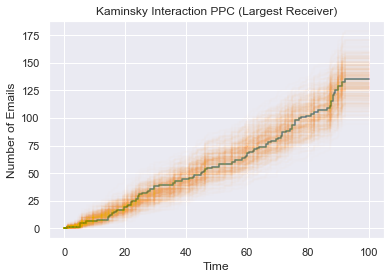

In [62]:
plt.plot(x, y)
for x_pp, y_pp in plots:
    plt.plot(x_pp, y_pp, alpha=0.01, color='orange')
plt.title('Kaminsky Interaction PPC (Largest Receiver)')
plt.ylabel('Number of Emails')
plt.xlabel('Time')

In [2]:
sorted([(1, 2, 3), (2, 2, 3), (0, 2, 3)])

[(0, 2, 3), (1, 2, 3), (2, 2, 3)]